In [1]:
import torch
torch.cuda.is_available()

True

In [3]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

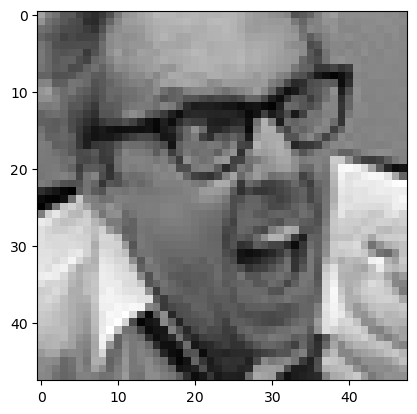

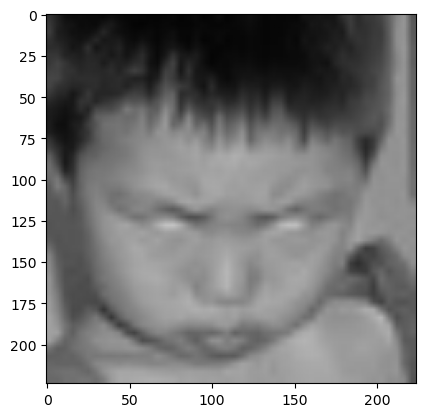

torch.Size([3, 224, 224])


In [3]:
img_size = 224

# Example code from your previous snippet...
img_array = cv.imread("C:\\Users\\hrugv\\OneDrive\\Desktop\\archive\\train\\0\\Training_3908.jpg")
img_array = cv.cvtColor(img_array, cv.COLOR_BGR2RGB)
plt.imshow(img_array)
plt.show()

DataDirectory = "C:\\Users\\hrugv\\OneDrive\\Desktop\\archive\\train"
Classes = ["0", "1", "2", "3", "4", "5", "6"]

class CustomDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        self.data_dir = data_dir
        self.classes = classes
        self.transform = transform
        self.training_data = self.create_training_data()

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        img_name, label = self.training_data[idx]
        img_path = os.path.join(self.data_dir, self.classes[label], img_name)
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(img)

        return img, label

    def create_training_data(self):
        training_data = []
        for label, category in enumerate(self.classes):
            path = os.path.join(self.data_dir, category)
            for img_name in os.listdir(path):
                training_data.append((img_name, label))
        return training_data

# Initialize custom dataset
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

custom_dataset = CustomDataset(DataDirectory, Classes, transform=transform)

# Example of how to access data from custom dataset
img, label = custom_dataset[0]
plt.imshow(img.permute(1, 2, 0))  # PyTorch tensors are (C, H, W), convert to (H, W, C) for plotting
plt.show()
print(img.shape)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.base_model = torchvision.models.mobilenet_v2(pretrained=True)
        self.base_model.classifier = nn.Sequential(
            nn.Linear(self.base_model.last_channel, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(Classes))
        )

    def forward(self, x):
        return self.base_model(x)

# Initialize the model
model = Net()

# Print model summary
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

Net(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1),

C:\Users\hrugv\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hrugv\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
import torch
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device (GPU or CPU)
model = model.to(device)

def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        # Initialize tqdm progress bar
        with tqdm(dataloader, unit="batch") as tepoch:
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
                
                # Move inputs and labels to the appropriate device (GPU or CPU)
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / (len(dataloader) * (tepoch.n + 1)))
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

# laoding the data 
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# we are defining the loss func 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
train_model(model, dataloader, criterion, optimizer, num_epochs=35)


Epoch 1/35: 100%|██████████| 898/898 [02:44<00:00,  5.46batch/s, loss=0.00144]


Epoch [1/35], Loss: 1.2951482547019797


Epoch 2/35: 100%|██████████| 898/898 [02:45<00:00,  5.41batch/s, loss=0.00126]


Epoch [2/35], Loss: 1.1315501483617754


Epoch 3/35: 100%|██████████| 898/898 [02:46<00:00,  5.40batch/s, loss=0.00117]


Epoch [3/35], Loss: 1.0543121950398044


Epoch 4/35: 100%|██████████| 898/898 [02:46<00:00,  5.38batch/s, loss=0.00112]


Epoch [4/35], Loss: 1.0023109101771246


Epoch 5/35: 100%|██████████| 898/898 [02:46<00:00,  5.38batch/s, loss=0.00106]


Epoch [5/35], Loss: 0.9563601022308281


Epoch 6/35: 100%|██████████| 898/898 [02:47<00:00,  5.36batch/s, loss=0.00102] 


Epoch [6/35], Loss: 0.9115058349275377


Epoch 7/35: 100%|██████████| 898/898 [02:46<00:00,  5.38batch/s, loss=0.000969]


Epoch [7/35], Loss: 0.8702874331338899


Epoch 8/35: 100%|██████████| 898/898 [02:46<00:00,  5.39batch/s, loss=0.00092] 


Epoch [8/35], Loss: 0.8258637493862075


Epoch 9/35: 100%|██████████| 898/898 [02:46<00:00,  5.41batch/s, loss=0.000879]


Epoch [9/35], Loss: 0.789510390706742


Epoch 10/35: 100%|██████████| 898/898 [02:46<00:00,  5.40batch/s, loss=0.000828]


Epoch [10/35], Loss: 0.7437354847622873


Epoch 11/35: 100%|██████████| 898/898 [02:45<00:00,  5.42batch/s, loss=0.000789]


Epoch [11/35], Loss: 0.7082684295446942


Epoch 12/35: 100%|██████████| 898/898 [02:45<00:00,  5.43batch/s, loss=0.000739]


Epoch [12/35], Loss: 0.6632874493875057


Epoch 13/35: 100%|██████████| 898/898 [02:45<00:00,  5.41batch/s, loss=0.000701]


Epoch [13/35], Loss: 0.6290974607380037


Epoch 14/35: 100%|██████████| 898/898 [02:45<00:00,  5.42batch/s, loss=0.000659]


Epoch [14/35], Loss: 0.5920156981206949


Epoch 15/35: 100%|██████████| 898/898 [02:45<00:00,  5.41batch/s, loss=0.000612]


Epoch [15/35], Loss: 0.5497011373893986


Epoch 16/35: 100%|██████████| 898/898 [02:46<00:00,  5.40batch/s, loss=0.00058] 


Epoch [16/35], Loss: 0.5209069531784292


Epoch 17/35: 100%|██████████| 898/898 [02:45<00:00,  5.41batch/s, loss=0.000542]


Epoch [17/35], Loss: 0.4865372737492113


Epoch 18/35: 100%|██████████| 898/898 [02:45<00:00,  5.41batch/s, loss=0.000506]


Epoch [18/35], Loss: 0.45457463898179523


Epoch 19/35: 100%|██████████| 898/898 [02:46<00:00,  5.40batch/s, loss=0.000479]


Epoch [19/35], Loss: 0.4300438318824715


Epoch 20/35: 100%|██████████| 898/898 [02:46<00:00,  5.41batch/s, loss=0.000456]


Epoch [20/35], Loss: 0.40922726667537984


Epoch 21/35: 100%|██████████| 898/898 [02:46<00:00,  5.40batch/s, loss=0.000426]


Epoch [21/35], Loss: 0.3824344131813482


Epoch 22/35: 100%|██████████| 898/898 [02:46<00:00,  5.41batch/s, loss=0.000412]


Epoch [22/35], Loss: 0.3695575626264171


Epoch 23/35: 100%|██████████| 898/898 [02:45<00:00,  5.41batch/s, loss=0.000388]


Epoch [23/35], Loss: 0.34827287508411237


Epoch 24/35: 100%|██████████| 898/898 [02:47<00:00,  5.37batch/s, loss=0.000348]


Epoch [24/35], Loss: 0.31277234395571835


Epoch 25/35: 100%|██████████| 898/898 [02:45<00:00,  5.43batch/s, loss=0.000356]


Epoch [25/35], Loss: 0.31980980477629767


Epoch 26/35: 100%|██████████| 898/898 [02:45<00:00,  5.42batch/s, loss=0.00033] 


Epoch [26/35], Loss: 0.29674906858589445


Epoch 27/35: 100%|██████████| 898/898 [02:46<00:00,  5.40batch/s, loss=0.000315]


Epoch [27/35], Loss: 0.28268887214611527


Epoch 28/35: 100%|██████████| 898/898 [02:46<00:00,  5.41batch/s, loss=0.000299]


Epoch [28/35], Loss: 0.2687838655649653


Epoch 29/35: 100%|██████████| 898/898 [02:46<00:00,  5.39batch/s, loss=0.000289]


Epoch [29/35], Loss: 0.25916537176817656


Epoch 30/35: 100%|██████████| 898/898 [02:46<00:00,  5.40batch/s, loss=0.000294]


Epoch [30/35], Loss: 0.26385196019171475


Epoch 31/35: 100%|██████████| 898/898 [02:46<00:00,  5.39batch/s, loss=0.000255]


Epoch [31/35], Loss: 0.22907666908265953


Epoch 32/35: 100%|██████████| 898/898 [02:45<00:00,  5.42batch/s, loss=0.000258]


Epoch [32/35], Loss: 0.2319990786846171


Epoch 33/35: 100%|██████████| 898/898 [02:45<00:00,  5.41batch/s, loss=0.000249]


Epoch [33/35], Loss: 0.2231926757049952


Epoch 34/35: 100%|██████████| 898/898 [02:45<00:00,  5.42batch/s, loss=0.000224]


Epoch [34/35], Loss: 0.20129243732494342


Epoch 35/35: 100%|██████████| 898/898 [02:45<00:00,  5.42batch/s, loss=0.000233]

Epoch [35/35], Loss: 0.2088679096709215


In [51]:
model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [5]:
torch.save(model.state_dict(), 'path_to_your_model.pth')
print("Model saved to path_to_your_model.pth")

Model saved to path_to_your_model.pth


In [4]:
frame=cv.imread("C://Users//hrugv//OneDrive//Desktop//man2.jpeg")

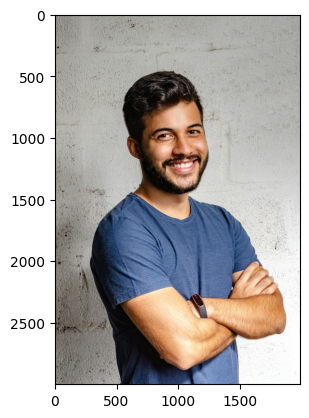

In [5]:
plt.imshow(cv.cvtColor(frame,cv.COLOR_BGR2RGB))


In [11]:
frame.shape

(3000, 1987, 3)

In [12]:
faceCascade = cv.CascadeClassifier(cv.data.haarcascades+'haarcascade_frontalface_default.xml')

In [13]:
gray=cv.cvtColor(frame,cv.COLOR_BGR2GRAY)

In [14]:
gray.shape

(3000, 1987)

In [15]:
faces=faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray=gray[y:y+h,x:x+w]
    roi_color=frame[y:y+h,x:x+w]
    cv.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    facess=faceCascade.detectMultiScale(roi_gray)
    if len(facess)==0:
        print("no face detected")
    else:
        for(ex,ey,ew,eh) in facess:
            face_roi =roi_color[ey:ey+eh,ex:ex+ew]

no face detected
no face detected


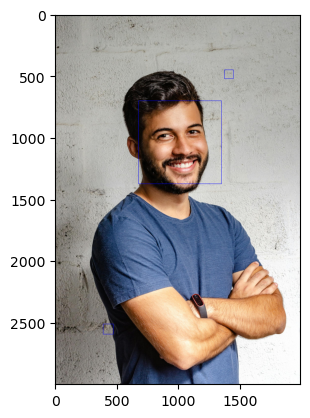

In [16]:
plt.imshow(cv.cvtColor(frame,cv.COLOR_BGR2RGB))

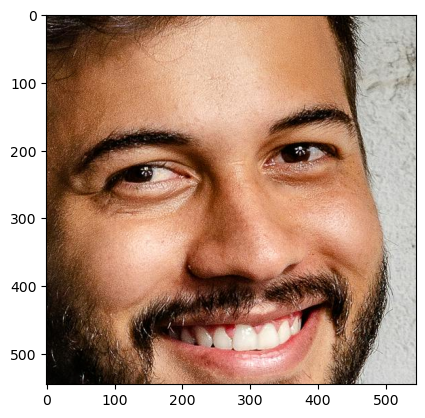

In [17]:
plt.imshow(cv.cvtColor(face_roi,cv.COLOR_BGR2RGB))

In [18]:
import numpy as np
final_image=cv.resize(face_roi,(224,224))
final_image=np.expand_dims(final_image,axis=0)
final_image=final_image/255.0

In [19]:
final_image.shape

(1, 224, 224, 3)

In [45]:
Predictions=model.predict(final_image)

AttributeError: 'Net' object has no attribute 'predict'

In [46]:
predictions = model(final_image)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [32;1mint[0m)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m, [31;1mParameter[0m, [31;1mNoneType[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [31;1mtuple of (int, int)[0m, [32;1mint[0m)


In [48]:
import torch
from torchvision import transforms
from PIL import Image

# Define the transformation to be applied to your input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize(           # Normalize the image
        mean=[0.485, 0.456, 0.406],  # These values are for ImageNet normalization
        std=[0.229, 0.224, 0.225]
    ),
])

# Load your model
model = torch.load('path_to_your_model.pth')
model.eval()  # Set the model to evaluation mode

# Load and transform your image
image = Image.open('path_to_your_image.jpg')  # Replace with your image path
image = transform(image)  # Apply the transformations

# Add a batch dimension (PyTorch expects batches)
image = image.unsqueeze(0)

# Make the prediction
with torch.no_grad():
    outputs = model(image)

# Get the predicted class
_, predicted = torch.max(outputs, 1)

# Print the predicted class (assuming your model outputs class indices)
print('Predicted class:', predicted.item())



AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [52]:
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
~\AppData\Local\Temp\ipykernel_29268\2029845769.py in <module>
----> 1 model.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

SyntaxError: invalid syntax (633323052.py, line 1)

In [59]:
import torch

# Load the saved model state dictionary
state_dict = torch.load('path_to_your_model.pth', map_location=torch.device('cpu'))

# Create an instance of your model class
model = YourModel()

# Selectively load the state dictionary
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# Set the model to evaluation mode
model.eval()

# Check if the model is on the correct device
if torch.cuda.is_available():
    model.to(torch.device('cuda'))

# Assuming you have a final_image tensor
final_image = final_image.unsqueeze(0)  # Add a batch dimension

# Move the input to the same device as the model
final_image = final_image.to(model.device)

with torch.no_grad():
    predictions = model(final_image)

# Now, you can work with the predictions tensor
# For example, you can get the class with the highest probability:
_, predicted_class = torch.max(predictions, 1)

# Move the predicted class back to the CPU if necessary
if predicted_class.device.type == 'cuda':
    predicted_class = predicted_class.to('cpu')

NameError: name 'YourModel' is not defined

In [56]:
import os
file_path = 'path_to_your_model.pth'
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    
    print(f"The file '{file_path}' does not exist.")

The file 'path_to_your_model.pth' exists.
